In [ ]:
#Resize notebook to full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import scipy

import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region, spectral_slab

from jdaviz import CubeViz

from photutils import CircularAperture, SkyCircularAperture, aperture_photometry
from photutils.detection import DAOStarFinder

from regions import PixCoord, CirclePixelRegion

from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.stats import sigma_clipped_stats
from astropy.utils.data import download_file
import astropy.units as u

/Users/pogle/miniconda3/envs/science/lib/python3.8/site-packages/glue/external/echo/__init__.py:3: UserWarning: glue.external.echo is deprecated, import from echo directly instead
  warnings.warn('glue.external.echo is deprecated, import from echo directly instead')


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [6]:
#%pip install jwst
#%pip install specutils 

In [151]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """ 
     
    if window_len<3:
        return x
    
    
    #if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
    #    raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
    

    pad=len(x[window_len-1:0:-1])-1
    print(pad)
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    
    y=np.convolve(w/w.sum(),s,mode='valid')
    pad=np.int((len(y)-len(x))/2)
    return y[pad:-pad]    



In [153]:
#Reconstruct Q3D input spectrum
template_dir = '/Users/pogle/Desktop/NIRSpec/IPS_IFU/q3d_ifu/Q3Dsims/'

qso_nir = template_dir + 'QSO_NIR_template.dat'
    
f=open(qso_nir)
lines=f.readlines()
print(lines[0:13])
datalines=lines[13:]

lam_nir=[]
fluxd_nir=[]
e_fluxd_nir=[]

for line in datalines:
    cols=line.split()
    ll=np.float(cols[0])
    ff=np.float(cols[1])
    ee=np.float(cols[2])
    lam_nir.append(ll)
    fluxd_nir.append(ff)
    e_fluxd_nir.append(ee)
    
lam_nir_arr=np.array(lam_nir)
fluxd_nir_arr=np.array(fluxd_nir)

qso_opt = template_dir + 'QSO_optical_template.dat'
    
f=open(qso_opt)
lines=f.readlines()
print(lines[0:12])
datalines=lines[12:]

lam_opt=[]
fluxd_opt=[]
e_fluxd_opt=[]

for line in datalines:
    cols=line.split()
    ll=np.float(cols[0])
    ff=np.float(cols[1])
    ee=np.float(cols[2])
    lam_opt.append(ll)
    fluxd_opt.append(ff)
    e_fluxd_opt.append(ee)
    
lam_opt_arr=np.array(lam_opt)
fluxd_opt_arr=np.array(fluxd_opt)

gal= template_dir + 'hlsp_galsedatlas_multi_multi_ngc-0337_multi_v1_spec.dat'
    
f=open(gal)
lines=f.readlines()
print(lines[0:9])
datalines=lines[9:]

lam_gal=[]
fluxd_gal=[]
#e_fluxd_gal=[]

for line in datalines:
    cols=line.split()
    ll=np.float(cols[0])
    ff=np.float(cols[1])
    #ee=np.float(cols[2])
    lam_gal.append(ll)
    fluxd_gal.append(ff)
    #e_fluxd_opt.append(ee)
    
lam_gal_arr=np.array(lam_gal)
fluxd_gal_arr=np.array(fluxd_gal) 

#Redshift
z=1.5
oiiilam=5007.
z_galtemplate= (5011.-oiiilam)/oiiilam   #Galaxy template redshift
z_qsotemplate= (5008.-oiiilam)/oiiilam   #Galaxy template redshift

#log flux scaling
logfscal_gal = -4.0   #Galaxy integrated flux ~ 10^-17 erg/s/cm^2/A  (10^-6 W/m^2/m)
logfscal_qso= -17.3    #QSO   integrated flux ~ 10^-17 erg/s/cm^2/A  (10^-6 W/m^2/m)

#Smoothing
smlen_opt=9
sspec_opt=smooth(fluxd_opt_arr,smlen_opt)
smlen_nir=13
sspec_nir=smooth(fluxd_nir_arr,smlen_nir)
smlen_gal=3
sspec_gal=smooth(fluxd_gal_arr,smlen_gal)

#QSO Trimming and Flux-matching
optscale=0.6
ntrim_opt=12
trim_opt=-1-ntrim_opt
lf_opt=np.log10(sspec_opt[0:trim_opt]/optscale)+logfscal_qso
lam_opt_trimmed=lam_opt_arr[0:trim_opt]
ll_opt=lam_opt_trimmed*(1+z)/(1.0E4*(1+z_qsotemplate))

good_nir=np.where(lam_nir_arr > lam_opt_trimmed[-1])[0]
bad_nir=np.where(lam_nir_arr <= lam_opt_trimmed[-1])[0]
lf_nir=np.log10(sspec_nir)[good_nir]+logfscal_qso
ll_nir=lam_nir_arr[good_nir]*(1+z)/(1.0E4*(1+z_qsotemplate))
lf_nir_bad=np.log10(sspec_nir)[bad_nir]+logfscal_qso
ll_nir_bad=lam_nir_arr[bad_nir]*(1+z)/(1.0E4*(1+z_qsotemplate))

#QSO Splicing
lf_spliced=np.concatenate((lf_opt,lf_nir))
ll_spliced=np.concatenate((ll_opt,ll_nir))

#Galaxy Trimming
good_gal=np.where(lam_gal_arr>0.)
lf_gal=np.log10(sspec_gal)[good_gal]+logfscal_gal
ll_gal=lam_gal_arr[good_gal]*(1+z)/(1.0E4*(1+z_galtemplate))




['Title: A Near-Infrared Spectral Template for Quasars \n', 'Authors: Glikman E., Helfand D.J., White R.L. \n', 'Table: Composite Quasar Spectrum, Arithmetic and Geometric Means\n', '================================================================================\n', 'Byte-by-byte Description of file: datafile3.txt\n', '--------------------------------------------------------------------------------\n', '   Bytes Format Units   Label  Explanations\n', '--------------------------------------------------------------------------------\n', '   1-  7 F7.1   0.1nm   Wave   Wavelength in Angstroms\n', '   9- 15 F7.4   ---     Flux   Arithmetic mean flux in arbitrary units \n', '  17- 23 F7.4   ---   e_Flux   Error in Flux \n', '  25- 31 F7.4   ---     GFlux  Geometric mean flux in arbitrary units\n', '--------------------------------------------------------------------------------\n']
['#Title: Composite Quasar Spectra From the Sloan Digital Sky Survey  \n', '#Authors: Vanden Berk D.E., Richa

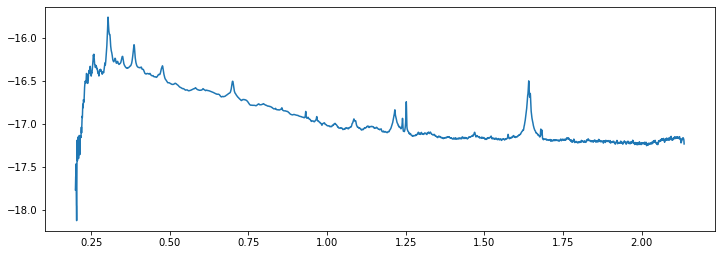

In [154]:
fig=plt.figure(figsize=(12,14))
ax1 = fig.add_subplot(311)
ax1.plot(ll_opt,lf_opt,zorder=10,label='9-bin-smoothed optical template (splice)')
plt.show()

In [90]:
# NIRSpec IFU science data cube
#BoxPath = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_optimal_extraction/"
Path = "/Users/pogle/Desktop/NIRSpec/IPS_IFU/q3d_ifu/jwst7/Day2020114/"
DirPrefix ="NRS00001-QG-F100LP-G140H-"
DirSuffix ="_JW1_IPS_20200423T120000.000_20200423T120000.000/"
Subdirs = ["01_1_1020","02_1_1021","03_1_1022","04_1_1023"]
FnamePrefix = "NRS00001-QG-F100LP-G140H-"
FnameSuffix_491 = "_1_491_SE_2020-04-23T12h15m00_s3d.fits"
FnameSuffix_492 = "_1_491_SE_2020-04-23T12h15m00_s3d.fits"
Fnames = ["01", "02", "03", "04"]
#fname = "NRS00001-faintQSO-F100LP-G140H-01_1_491_SE_2020-08-25T12h15m00_s3d.fits"

#Trim regions
wave_trim =[1.0*u.um,1.4*u.um]
x_trim = [2,-1]
y_trim = [5, -4]

# Open and inspect the file with astropy.fits.open
sci_491 = [] 
err_491 = []
spec1d_untrimmed = []
wavelength_untrimmed = []
spec1d = []
wavelength = []
for Subdir, Fname in zip (Subdirs, Fnames):
    fname_491 = Path + DirPrefix + Subdir + DirSuffix + FnamePrefix + Fname + FnameSuffix_491
    #fname_492 = Path + DirPrefix + Subdir + DirSuffix + FnamePrefix + Fname + FnameSuffix_492
    with fits.open(fname_491, memmap=False) as hdulist:
        hdulist.info()
        sci_491.append(hdulist['SCI'].data)
        err_491.append(hdulist['ERR'].data)  
    # Load original (untrimmed version) with Spectrum1D   
    s1du = Spectrum1D.read(fname_491, format='JWST s3d')
    waveu = s1du.spectral_axis
    spec1d_untrimmed.append(s1du)
    wavelength_untrimmed.append(waveu) 
    # Trim the data cube and adjust region location
    s1d = spectral_slab(s1du, wave_trim[0], wave_trim[1])  #[x_trim[0]:x_trim[1],y_trim[0]:y_trim[1],:]
    wave = s1d.spectral_axis
    spec1d.append(s1d)
    wavelength.append(wave)


Filename: /Users/pogle/Desktop/NIRSpec/IPS_IFU/q3d_ifu/jwst7/Day2020114/NRS00001-QG-F100LP-G140H-01_1_1020_JW1_IPS_20200423T120000.000_20200423T120000.000/NRS00001-QG-F100LP-G140H-01_1_491_SE_2020-04-23T12h15m00_s3d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     292   ()      
  1  SCI           1 ImageHDU        64   (49, 51, 2059)   float32   
  2  ERR           1 ImageHDU        12   (49, 51, 2059)   float32   
  3  DQ            1 ImageHDU        12   (49, 51, 2059)   int32 (rescales to uint32)   
  4  WMAP          1 ImageHDU        10   (49, 51, 2059)   float32   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [10550B]   
Filename: /Users/pogle/Desktop/NIRSpec/IPS_IFU/q3d_ifu/jwst7/Day2020114/NRS00001-QG-F100LP-G140H-02_1_1021_JW1_IPS_20200423T120000.000_20200423T120000.000/NRS00001-QG-F100LP-G140H-02_1_491_SE_2020-04-23T12h15m00_s3d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1

16151783407616.0 0.0 27670987407360.0
Sources detected in data:
 id xcentroid ycentroid sharpness ... sky     peak      flux    mag   
--- --------- --------- --------- ... --- ----------- ------- --------
  1   25.5618   26.1272  0.650815 ...   0 2.70597e+17 177.716 -5.62432

15277450330112.0 0.0 25380052271104.0
Sources detected in data:
 id xcentroid ycentroid sharpness ... sky     peak      flux    mag   
--- --------- --------- --------- ... --- ----------- ------- --------
  1   25.8395   21.4915  0.551663 ...   0 2.09861e+17 161.315 -5.51919

17553744199680.0 0.0 30859105140736.0
Sources detected in data:
 id xcentroid ycentroid sharpness ... sky     peak      flux    mag   
--- --------- --------- --------- ... --- ----------- ------- --------
  1   27.2192   24.7893  0.779026 ...   0 3.04999e+17 160.986 -5.51697

15513419776000.0 0.0 26192367321088.0
Sources detected in data:
 id xcentroid ycentroid sharpness ... sky     peak      flux    mag   
--- --------- --------- -------

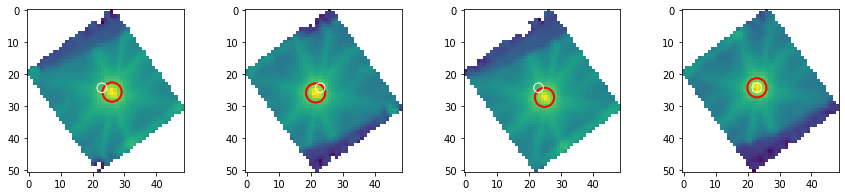

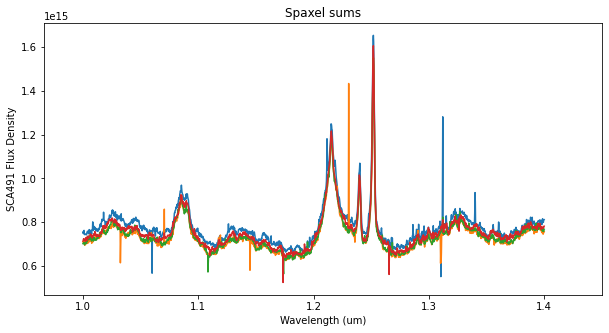

In [260]:
#Use photutils.aperture_photometry to measure flux in expanding aperture for first nod
#center_xy = [[26, 25.7], [21.8, 25.7], [24.8, 26.9], [22.8, 23.8]]
center_xy =[[25.5618, 26.1272], [25.8395, 21.4915], [27.2192, 24.7893], [24.2238,22.9149]]
r_pix = 3.0
center=[]
region=[]
for  cen in center_xy:
    centr = PixCoord(x=cen[0], y=cen[1])
    center.append(centr)
    centr_xy_flipped = PixCoord(x=cen[1], y=cen[0])
    region.append(CirclePixelRegion(center=centr_xy_flipped, radius=r_pix))

ref_center = region[3].center
ref = CirclePixelRegion(center=ref_center, radius=1.5 )
#Plot 
f, ([ax1,ax2,ax3,ax4] ) = plt.subplots(1, 4, figsize=(15, 3)) 

#Sum over wavelength
for spec,reg,ax in zip(spec1d, region, [ax1, ax2, ax3, ax4]):
    cube_sum = np.sum(spec.flux.value, axis=2)

    #Find source
    data_mean, data_median, data_std = sigma_clipped_stats(cube_sum, sigma=3.0) 
    print(data_mean, data_median, data_std)
    daofind = DAOStarFinder(fwhm=3.0, threshold=50.*data_std)
    data_sources = daofind((cube_sum)-data_median) 
    for col in data_sources.colnames:  
        data_sources[col].info.format = '%.6g'  
    print("Sources detected in data:")
    print(data_sources)  
    print()
    
    ax.imshow(np.transpose(cube_sum), norm=LogNorm())
    patch = reg.as_artist(facecolor='none', edgecolor='red', lw=2)
    ref_patch = ref.as_artist(facecolor='none', edgecolor='white', lw=1)
    ax.add_patch(patch)
    ax.add_patch(ref_patch)

plt.show()

#Plot 
f, (ax5) = plt.subplots(1, 1, figsize=(10, 5)) 

ax5.set_xlim(wavelength_untrimmed[0].value[0], wavelength_untrimmed[0].value[-1])
ax5.set_title("Spaxel sums")
ax5.set_xlabel("Wavelength (um)")  
ax5.set_ylabel("SCA491 Flux Density")

for spec in spec1d:
    # Sum over spaxels
    fnu_sum = np.sum(spec.flux, axis=(0, 1))
    ax5.plot(wavelength[0], fnu_sum)
    
plt.show()

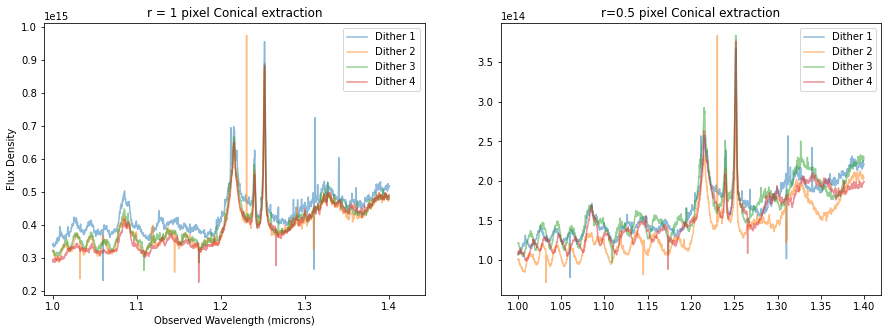

In [261]:
# Conical Extractions for three different apertures

#Plot
f, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(15, 5)) 

ax1.set_title("r = 1 pixel Conical extraction")
ax1.set_xlabel("Observed Wavelength (microns)")  
ax1.set_ylabel("Flux Density")
ax1.set_xlim(0.99, 1.442)

ax2.set_title("r=0.5 pixel Conical extraction")


spec1d_len = len(wavelength[0])
cone_wide = []
cone_med = []
cone_narrow = []
for spec, centr, dither in zip(spec1d, center, ['1','2','3','4']):
    cone_sum1 = []
    r_pix=2.0
    for idx in range(spec1d_len):
        r_cone = r_pix * wavelength[0].value[idx]/ wavelength[0].value[0]
        aperture_cone = CircularAperture((centr.x, centr.y), r=r_cone)
        #print(aperture_cone)
        phot_table = aperture_photometry(spec.flux.value[:, :, idx], aperture_cone)
        cone_sum1.append(phot_table['aperture_sum'][0])
    cone1 = Spectrum1D(flux=np.array(cone_sum1)*u.MJy/u.sr, spectral_axis=spec1d[0].spectral_axis)
    cone_wide.append(cone1)
    #ax1.plot(wavelength[0], cone1.flux.value, label="Dither " + dither, alpha=0.5)

    cone_sum2 = []
    r_pix=1.0
    for idx in range(spec1d_len):
        r_cone = r_pix * wavelength[0].value[idx]/ wavelength[0].value[0]
        aperture_cone = CircularAperture((centr.x, centr.y), r=r_cone)
        #print(aperture_cone)
        phot_table = aperture_photometry(spec.flux.value[:, :, idx], aperture_cone)
        cone_sum2.append(phot_table['aperture_sum'][0])
    cone2 = Spectrum1D(flux=np.array(cone_sum2)*u.MJy/u.sr, spectral_axis=spec1d[0].spectral_axis)
    cone_med.append(cone2)
    ax1.plot(wavelength[0], cone2.flux.value, label="Dither " + dither, alpha=0.5)
    
    cone_sum3 = []
    r_pix=0.5
    for idx in range(spec1d_len):
        r_cone = r_pix * wavelength[0].value[idx]/ wavelength[0].value[0]
        aperture_cone = CircularAperture((centr.x,centr.y), r=r_cone)
        phot_table = aperture_photometry(spec.flux.value[:, :, idx], aperture_cone)
        cone_sum3.append(phot_table['aperture_sum'][0])
    cone3 = Spectrum1D(flux=np.array(cone_sum3)*u.MJy/u.sr, spectral_axis=spec1d[0].spectral_axis)
    cone_narrow.append(cone3)
    ax2.plot(wavelength[0], cone3.flux.value, label="Dither " + dither, alpha=0.5)

ax1.legend()
ax2.legend()
plt.show()


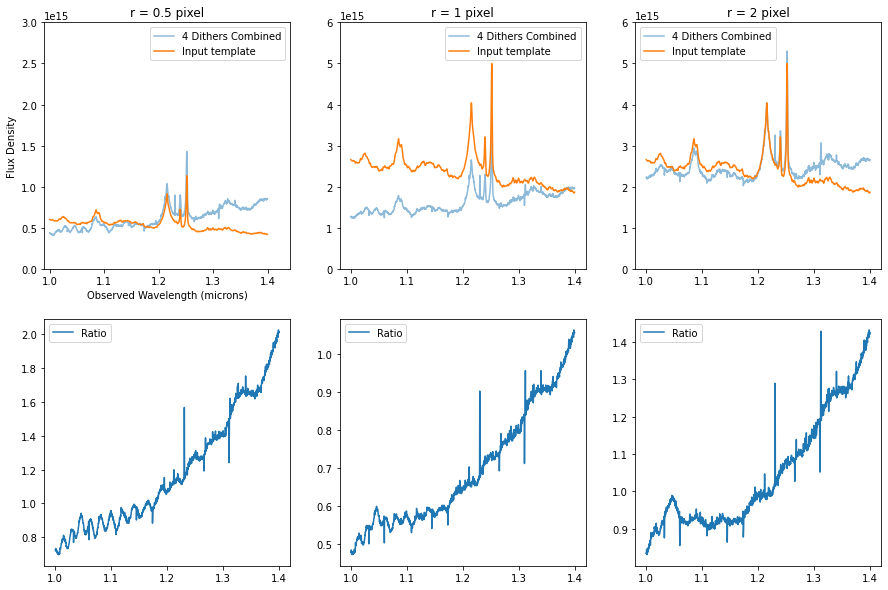

In [262]:
cone_narrow_sum=cone_narrow[0].flux.value-cone_narrow[0].flux.value
for spec in cone_narrow: cone_narrow_sum+=spec.flux.value
    
cone_med_sum=cone_med[0].flux.value-cone_med[0].flux.value
for spec in cone_med: cone_med_sum+=spec.flux.value
    
cone_wide_sum=cone_wide[0].flux.value-cone_wide[0].flux.value
for spec in cone_wide: cone_wide_sum+=spec.flux.value
    
f_scaled = 10**(lf_opt + 31.8)
f_interp_narrow = np.interp(wavelength[0].value, ll_opt, f_scaled)
f_interp_med = f_interp_narrow * 4.4
f_interp_wide = f_interp_med

f, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(15, 10)) 

ax1.set_title("r = 0.5 pixel")
ax2.set_title("r = 1 pixel")
ax3.set_title("r = 2 pixel")
ax1.set_xlabel("Observed Wavelength (microns)")  
ax1.set_ylabel("Flux Density")
ax1.set_xlim(0.99, 1.442)
ax1.set_ylim(0, 3E15)
ax2.set_ylim(0, 6E15)
ax3.set_ylim(0, 6E15)

ax1.plot(wavelength[0], cone_narrow_sum, label="4 Dithers Combined", alpha=0.5)
ax1.plot(wavelength[0],f_interp_narrow,zorder=10,label='Input template')
ax1.legend()

ax2.plot(wavelength[0], cone_med_sum, label="4 Dithers Combined", alpha=0.5)
ax2.plot(wavelength[0],f_interp_med,zorder=10,label='Input template')
ax2.legend()

ax3.plot(wavelength[0], cone_wide_sum, label="4 Dithers Combined", alpha=0.5)
ax3.plot(wavelength[0],f_interp_wide,zorder=10,label='Input template')
ax3.legend()


ax4.plot(wavelength[0],cone_narrow_sum/f_interp_narrow,zorder=10,label='Ratio')
ax4.legend()

ax5.plot(wavelength[0],cone_med_sum/f_interp_med,zorder=10,label='Ratio')
ax5.legend()

ax6.plot(wavelength[0],cone_wide_sum/f_interp_wide,zorder=10,label='Ratio')
ax6.legend()

plt.show()

Shift (x,y) =  -3.212299999999999 -1.338000000000001

Shift (x,y) =  1.4234000000000009 -1.6157000000000004

Shift (x,y) =  -1.8744000000000014 -2.9954



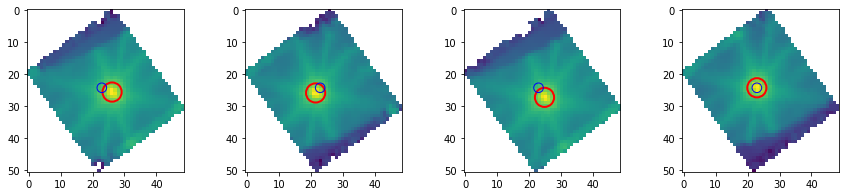

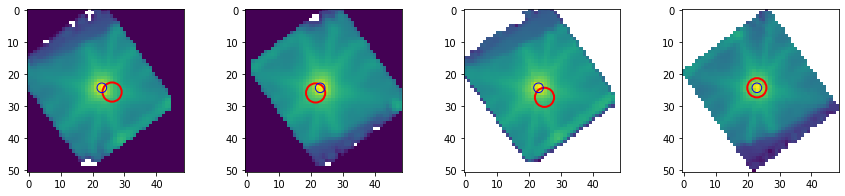

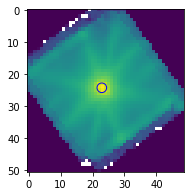

In [272]:
#Register cubes to 4th dither:

spec1d_aligned = []
spec1d_aligned_sum = []
for s1d, cxy in zip(spec1d, center_xy[0:3]):
    shifty = center_xy[3][0]-cxy[0]
    shiftx = center_xy[3][1]-cxy[1]
    print("Shift (x,y) = ", shiftx, shifty)
    print()
    s1d_aligned = scipy.ndimage.shift(s1d.flux.value, (shiftx, shifty, 0.0), order=1, 
                                        mode='constant', cval=0.0, prefilter=True)
    spec1d_aligned.append(s1d_aligned)
    spec1d_aligned_sum.append(np.sum(s1d_aligned, axis=2))

spec1d_aligned.append(spec1d[3].flux.value)
spec1d_aligned_sum.append(np.sum(spec1d[3].flux.value, axis=2))

#Plot 
f, ([ax1,ax2,ax3,ax4] ) = plt.subplots(1, 4, figsize=(15, 3)) 

#Sum over wavelength
for spec,reg,ax in zip(spec1d, region, [ax1, ax2, ax3, ax4]):
    cube_sum = np.sum(spec.flux.value, axis=2)
    
    ax.imshow(np.transpose(cube_sum), norm=LogNorm())
    patch = reg.as_artist(facecolor='none', edgecolor='red', lw=2)
    ref_patch = ref.as_artist(facecolor='none', edgecolor='blue', lw=1)
    ax.add_patch(patch)
    ax.add_patch(ref_patch)

plt.show()

#Plot 
f, ([ax1,ax2,ax3,ax4] ) = plt.subplots(1, 4, figsize=(15, 3)) 

#Display and sum the dithers
dither_sum = spec1d_aligned[0] - spec1d_aligned[0]
dither_cube_sum = spec1d_aligned_sum[0] - spec1d_aligned_sum[0]
for spec,cube_sum, reg,ax in zip(spec1d_aligned, spec1d_aligned_sum, region, [ax1, ax2, ax3, ax4]):
    dither_sum += spec
    dither_cube_sum += cube_sum
    ax.imshow(np.transpose(cube_sum), norm=LogNorm())
    patch = reg.as_artist(facecolor='none', edgecolor='red', lw=2)
    ref_patch = ref.as_artist(facecolor='none', edgecolor='blue', lw=1)
    ax.add_patch(patch)
    ax.add_patch(ref_patch)
    
plt.show()

spec1d_combined = Spectrum1D(flux=np.array(dither_sum)*u.MJy/u.sr, spectral_axis=spec1d[0].spectral_axis)

f, (ax ) = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(np.transpose(dither_cube_sum), norm=LogNorm())
#patch = reg.as_artist(facecolor='none', edgecolor='red', lw=2)
ref_patch = ref.as_artist(facecolor='none', edgecolor='blue', lw=1)
#ax.add_patch(patch)
ax.add_patch(ref_patch)
plt.show()



In [276]:
#Re-do conical spectral extractions on combined cube
cone_sum1 = []
r_pix=2.0
spec = spec1d_combined
centr = center[3]
for idx in range(spec1d_len):
    r_cone = r_pix * wavelength[0].value[idx]/ wavelength[0].value[0]
    aperture_cone = CircularAperture((centr.x, centr.y), r=r_cone)
    #print(aperture_cone)
    phot_table = aperture_photometry(spec.flux.value[:, :, idx], aperture_cone)
    cone_sum1.append(phot_table['aperture_sum'][0])
cone1 = Spectrum1D(flux=np.array(cone_sum1)*u.MJy/u.sr, spectral_axis=spec1d[0].spectral_axis)

cone_sum2 = []
r_pix=1.0
for idx in range(spec1d_len):
    r_cone = r_pix * wavelength[0].value[idx]/ wavelength[0].value[0]
    aperture_cone = CircularAperture((centr.x, centr.y), r=r_cone)
    #print(aperture_cone)
    phot_table = aperture_photometry(spec.flux.value[:, :, idx], aperture_cone)
    cone_sum2.append(phot_table['aperture_sum'][0])
cone2 = Spectrum1D(flux=np.array(cone_sum2)*u.MJy/u.sr, spectral_axis=spec1d[0].spectral_axis)
    
cone_sum3 = []
r_pix=0.5
for idx in range(spec1d_len):
    r_cone = r_pix * wavelength[0].value[idx]/ wavelength[0].value[0]
    aperture_cone = CircularAperture((centr.x,centr.y), r=r_cone)
    phot_table = aperture_photometry(spec.flux.value[:, :, idx], aperture_cone)
    cone_sum3.append(phot_table['aperture_sum'][0])
cone3 = Spectrum1D(flux=np.array(cone_sum3)*u.MJy/u.sr, spectral_axis=spec1d[0].spectral_axis)

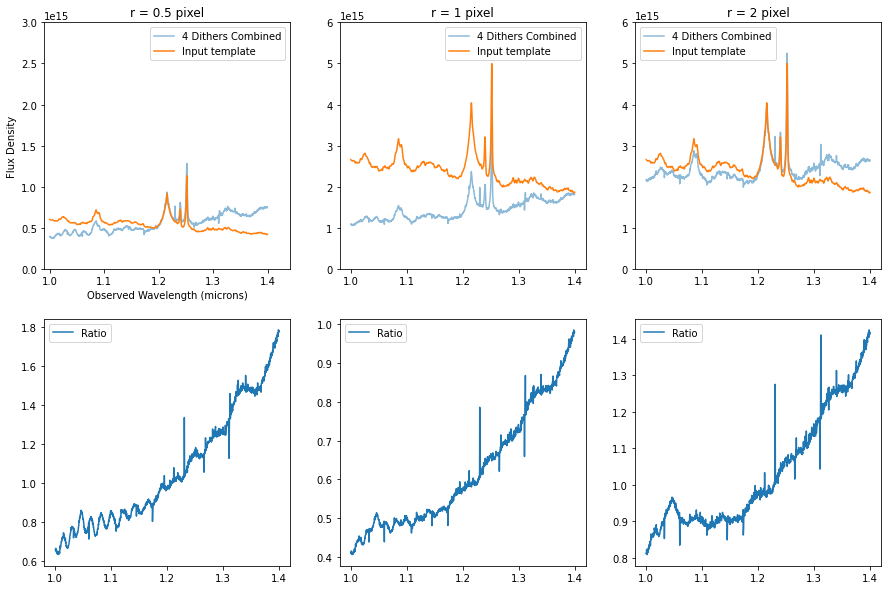

In [277]:
cone_narrow_sum=cone_sum3   
cone_med_sum=cone_sum2
cone_wide_sum=cone_sum1

f, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(15, 10)) 

ax1.set_title("r = 0.5 pixel")
ax2.set_title("r = 1 pixel")
ax3.set_title("r = 2 pixel")
ax1.set_xlabel("Observed Wavelength (microns)")  
ax1.set_ylabel("Flux Density")
ax1.set_xlim(0.99, 1.442)
ax1.set_ylim(0, 3E15)
ax2.set_ylim(0, 6E15)
ax3.set_ylim(0, 6E15)

ax1.plot(wavelength[0], cone_narrow_sum, label="4 Dithers Combined", alpha=0.5)
ax1.plot(wavelength[0],f_interp_narrow,zorder=10,label='Input template')
ax1.legend()

ax2.plot(wavelength[0], cone_med_sum, label="4 Dithers Combined", alpha=0.5)
ax2.plot(wavelength[0],f_interp_med,zorder=10,label='Input template')
ax2.legend()

ax3.plot(wavelength[0], cone_wide_sum, label="4 Dithers Combined", alpha=0.5)
ax3.plot(wavelength[0],f_interp_wide,zorder=10,label='Input template')
ax3.legend()


ax4.plot(wavelength[0],cone_narrow_sum/f_interp_narrow,zorder=10,label='Ratio')
ax4.legend()

ax5.plot(wavelength[0],cone_med_sum/f_interp_med,zorder=10,label='Ratio')
ax5.legend()

ax6.plot(wavelength[0],cone_wide_sum/f_interp_wide,zorder=10,label='Ratio')
ax6.legend()

plt.show()